In [1]:
# Import libraries
import yfinance as yf
import numpy as np
from stockstats import StockDataFrame as Sdf
import pandas as pd 
import quandl
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from urllib.request import urlopen, Request
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import datetime as dt
import time
plt.style.use('ggplot')
quandl.ApiConfig.api_key = "tgJvn_S9mLsWRyVsbMzy"

In [2]:
unemployment = quandl.get(["FRED/UNRATE"],
    trim_start="2015-01-01", trim_end="2020-11-01", collapse = 'monthly')
unemployment.columns = ['Unemployment']
Price_index = quandl.get(["FRED/CUUR0000SA0R"],\
    trim_start="2015-01-01", trim_end="2020-12-01", collapse = 'monthly')
Price_index.columns = ['Consumer Price Index']
AAPL_data = yf.download('AAPL','2015-01-01','2020-12-01')
AAPL_data = AAPL_data.dropna()
AAPL_data
AAPL_data=Sdf.retype(AAPL_data)
AAPL_data['macd']=AAPL_data['macd'] #macd s is 26 avr and h is 12 ave
AAPL_data['boll']=AAPL_data['boll'] #upper boll
AAPL_data['boll_lb']=AAPL_data['boll_lb'] #middle STD
AAPL_data['boll_lb']=AAPL_data['boll_lb'] #lower boll
AAPL_data['volume_delta']=AAPL_data['volume_delta'] #volume compared to yesterday
AAPL_data['dma']=AAPL_data['dma'] #diff between 10 and 50 moving avg
AAPL_data['close_-1_r'] = AAPL_data['close_-1_r']  #price change in rate
AAPL_data = pd.concat([Price_index,unemployment, AAPL_data], axis=1)
AAPL_data = AAPL_data.fillna(method='ffill')
AAPL_data = AAPL_data.fillna(method='bfill')
AAPL_data = AAPL_data.iloc[3:]
AAPL_data

[*********************100%***********************]  1 of 1 completed


,Consumer Price Index,Unemployment,open,high,low,close,adj close,volume,macd,macds,...,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,volume_delta,close_10_sma,close_50_sma,dma,close_-1_r
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,42.8,5.7,26.799999,27.049999,26.674999,26.937500,24.339447,160423600.0,-0.010068,-0.013100,...,26.849375,0.367125,26.849375,27.583625,26.115125,-102764800.0,26.849375,26.849375,0.000000,1.402219
2015-01-08,42.8,5.7,27.307501,28.037500,27.174999,27.972500,25.274624,237458000.0,0.037778,0.002035,...,27.074000,0.594447,27.074000,28.262894,25.885106,77034400.0,27.074000,27.074000,0.000000,3.842227
2015-01-09,42.8,5.7,28.167500,28.312500,27.552500,28.002501,25.301731,214798000.0,0.067112,0.019674,...,27.228750,0.652977,27.228750,28.534705,25.922796,-22660000.0,27.228750,27.228750,0.000000,0.107251
2015-01-12,42.8,5.7,28.150000,28.157499,27.200001,27.312500,24.678280,198603200.0,0.053510,0.028237,...,27.240714,0.596924,27.240714,28.434562,26.046867,-16194800.0,27.240714,27.240714,0.000000,-2.464068
2015-01-13,42.8,5.7,27.857500,28.200001,27.227501,27.555000,24.897392,268367600.0,0.055063,0.034684,...,27.280000,0.563704,27.280000,28.407409,26.152592,69764400.0,27.280000,27.280000,0.000000,0.887873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,38.4,6.9,117.180000,117.620003,113.750000,113.849998,113.849998,127959300.0,0.488706,0.651289,...,116.082999,3.671484,116.082999,123.425967,108.740032,54567900.0,118.148000,115.399800,2.748200,-2.974261
2020-11-24,38.4,6.9,113.910004,115.849998,112.589996,115.169998,115.169998,113874200.0,0.289593,0.578949,...,116.011499,3.674808,116.011499,123.361116,108.661883,-14085100.0,118.067999,115.392400,2.675600,1.159420
2020-11-25,38.4,6.9,115.550003,116.750000,115.169998,116.029999,116.029999,76499200.0,0.198897,0.502939,...,116.252999,3.496340,116.252999,123.245679,109.260320,-37375000.0,117.721999,115.470400,2.251600,0.746723


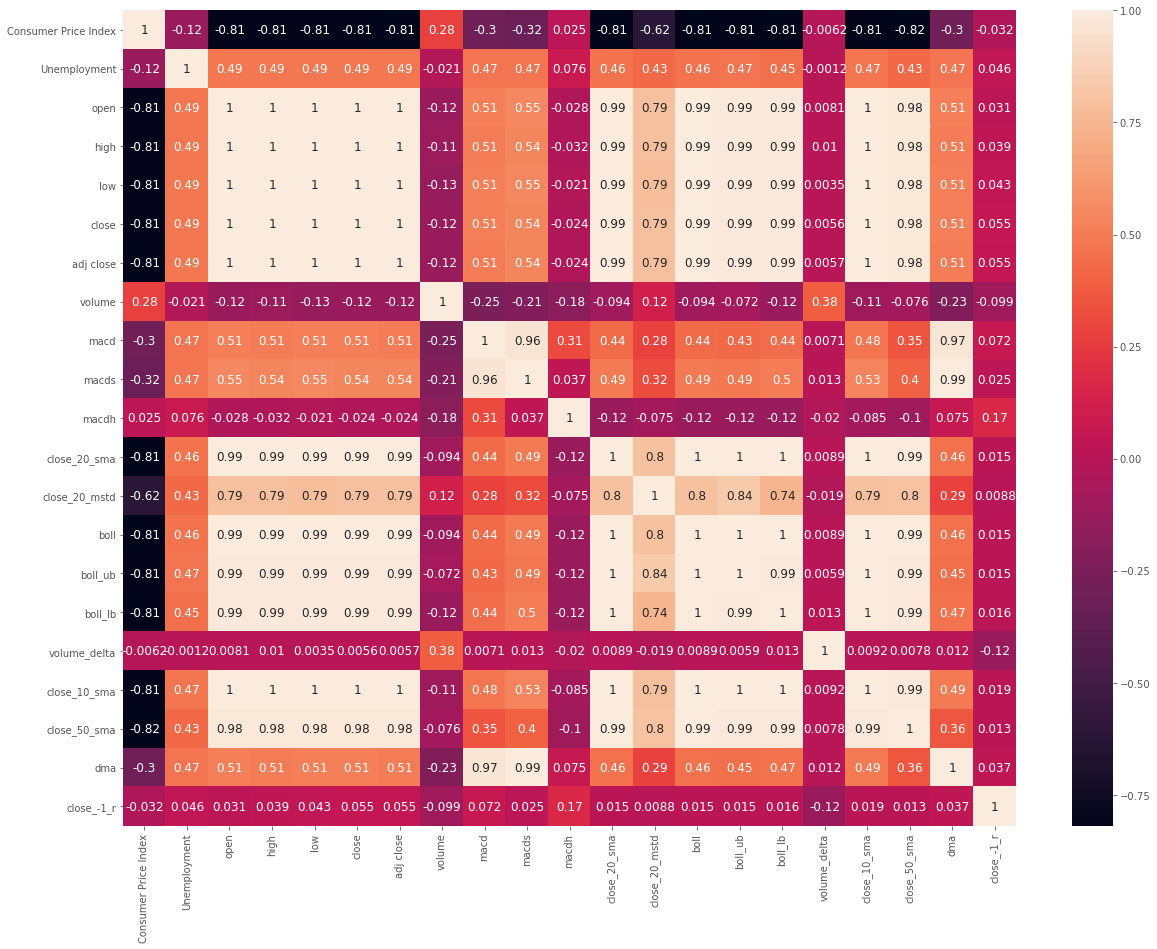

In [3]:
# check the correlation of the features 
AAPL_data = AAPL_data.dropna()
corr = AAPL_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [4]:
# went up or down zero is up one is down 
AAPL_data['pred_price'] = np.where(AAPL_data['close'].shift(-1) > AAPL_data['close'], 0, 1)
#AAPL_data.tail(10)
#AAPL_data['pred_price'].unique()

In [5]:
# all econimic indicators are inputs and our output will be the up or down col(last col)
y = AAPL_data['pred_price']
x = AAPL_data.drop(columns = ['pred_price', 'close', 'adj close','volume_delta','volume']) # to avoid overfitting 

In [6]:
# split train and test 
train_x = x[:'2019-12-31'] 
test_x  = x['2020-01-01':] 
train_y = y[: '2019-12-31'] 
test_y  = y['2020-01-01': ] 
# scale the data
scaler = MinMaxScaler(feature_range = (0,1)) 
train_x_scaled = scaler.fit_transform(train_x)

#print(train_x_scaled)
#

In [7]:
# classification models 
# dictinary to hold ML classification methods
classifiers = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=5000),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": svm.SVC(gamma = 'auto'),
    "Gradient Boosting Classifier": XGBClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Neural Net": MLPClassifier(solver='adam', alpha=0.0001,learning_rate='constant', learning_rate_init=0.001),
    "Naive Bayes": GaussianNB()
}
no_classifiers = len(classifiers.keys())

# classification function
def batch_classify(train_x_scaled, train_y, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), 
                              columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = time.process_time()
        classifier.fit(train_x_scaled, train_y)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(train_x_scaled, train_y)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.3f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [8]:
# classify for all methods and get results
df_results = batch_classify(train_x_scaled, train_y)
df_results= df_results.sort_values(by='train_score', ascending=True)
df_results

trained Logistic Regression in 0.109 s
trained Nearest Neighbors in 0.000 s
trained Support Vector Machine in 0.250 s
trained Gradient Boosting Classifier in 0.203 s
trained Decision Tree in 0.031 s
trained Random Forest in 0.516 s
trained Neural Net in 2.469 s
trained Naive Bayes in 0.000 s


,classifier,train_score,training_time
7,Naive Bayes,0.505106,0.000000
2,Support Vector Machine,0.522388,0.250000
0,Logistic Regression,0.549882,0.109375
6,Neural Net,0.555381,2.468750
1,Nearest Neighbors,0.680283,0.000000
3,Gradient Boosting Classifier,0.787903,0.203125
4,Decision Tree,0.997643,0.031250
5,Random Forest,0.997643,0.515625


In [9]:
# Cross-validation to check for pverfitting 
# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_scores = cross_val_score(log_reg, train_x_scaled, train_y, cv=5)
log_reg_mean = log_scores.mean()
# SVC
svc_clf = svm.SVC(gamma='auto')
svc_scores = cross_val_score(svc_clf, train_x_scaled, train_y, cv=5)
svc_mean = svc_scores.mean()
# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, train_x_scaled, train_y, cv=5)
knn_mean = knn_scores.mean()
# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, train_x_scaled, train_y, cv=5)
tree_mean = tree_scores.mean()
# Gradient Boosting Classifier
grad_clf = XGBClassifier()
grad_scores = cross_val_score(grad_clf, train_x_scaled, train_y, cv=5)
grad_mean = grad_scores.mean()
# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=100)
rand_scores = cross_val_score(rand_clf, train_x_scaled, train_y, cv=5)
rand_mean = rand_scores.mean()
# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=0.0001, max_iter=5000)
neural_scores = cross_val_score(neural_clf, train_x_scaled, train_y, cv=5)
neural_mean = neural_scores.mean()
# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, train_x_scaled, train_y, cv=5)
nav_mean = neural_scores.mean()
# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Regression.', 'Support Vector Machine', 'Nearest Neighbors', 'Decision Tree', 'Gradient Boosting Classifier', 'Random Forest', 'Neural Net ', 'Naive Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}
result_df_CV = pd.DataFrame(data=d)
result_df_CV = result_df_CV.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df_CV

,Classifiers,Crossval Mean Scores
1,Support Vector Machine,0.515303
0,Logistic Regression.,0.484638
6,Neural Net,0.461924
7,Naive Bayes,0.461924
3,Decision Tree,0.457984
5,Random Forest,0.453241
4,Gradient Boosting Classifier,0.449316
2,Nearest Neighbors,0.432033


accuracy score:
0.5341880341880342


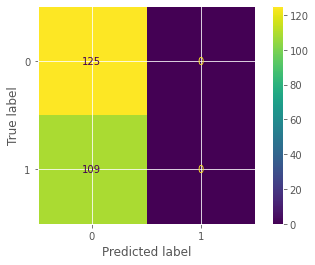

In [10]:
# estimate accuracy on validation dataset
test_x_scaled = scaler.transform(test_x)
#SVC
SVC = svm.SVC(gamma = 'auto')
clf=SVC.fit(train_x_scaled, train_y)
predictions = SVC.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
plot_confusion_matrix(clf,test_x, test_y)  
plt.show()

accuracy score:
0.5854700854700855
confusion matrix: 
[[86 39]
 [58 51]]


[Text(0, 0.5, 'UP'), Text(0, 1.5, 'DOWN')]

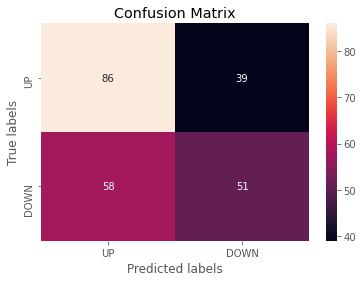

In [11]:
# Gradient Boosting Classifier
xgb = XGBClassifier()
clf_xgb = xgb.fit(train_x_scaled, train_y)
predictions = xgb.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
cm=confusion_matrix(test_y, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['UP', 'DOWN']); ax.yaxis.set_ticklabels(['UP', 'DOWN'])

accuracy score:
0.5427350427350427
confusion matrix: 
[[109  16]
 [ 91  18]]


[Text(0, 0.5, 'UP'), Text(0, 1.5, 'DOWN')]

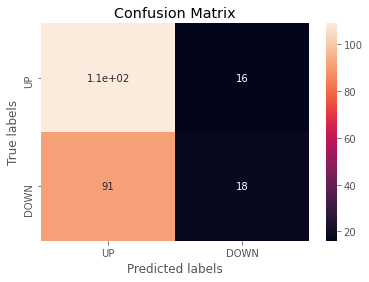

In [12]:
# Random Forest 
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_x_scaled, train_y)
predictions = rf.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))

cm=confusion_matrix(test_y, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['UP', 'DOWN']); ax.yaxis.set_ticklabels(['UP','DOWN' ])

accuracy score:
0.47863247863247865
confusion matrix: 
[[ 13 112]
 [ 10  99]]


[Text(0, 0.5, 'UP'), Text(0, 1.5, 'DOWN')]

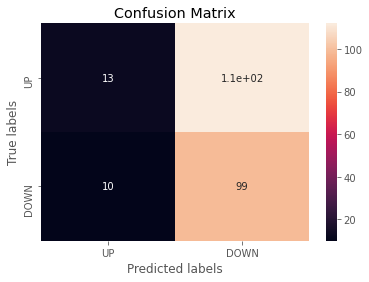

In [13]:
# logistic Regression 
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_reg.fit(train_x_scaled, train_y)
predictions = log_reg.predict(test_x_scaled)
print("accuracy score:")
print(accuracy_score(test_y, predictions))
print("confusion matrix: ")
print(confusion_matrix(test_y, predictions))
cm=confusion_matrix(test_y, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['UP', 'DOWN']); ax.yaxis.set_ticklabels(['UP','DOWN'])

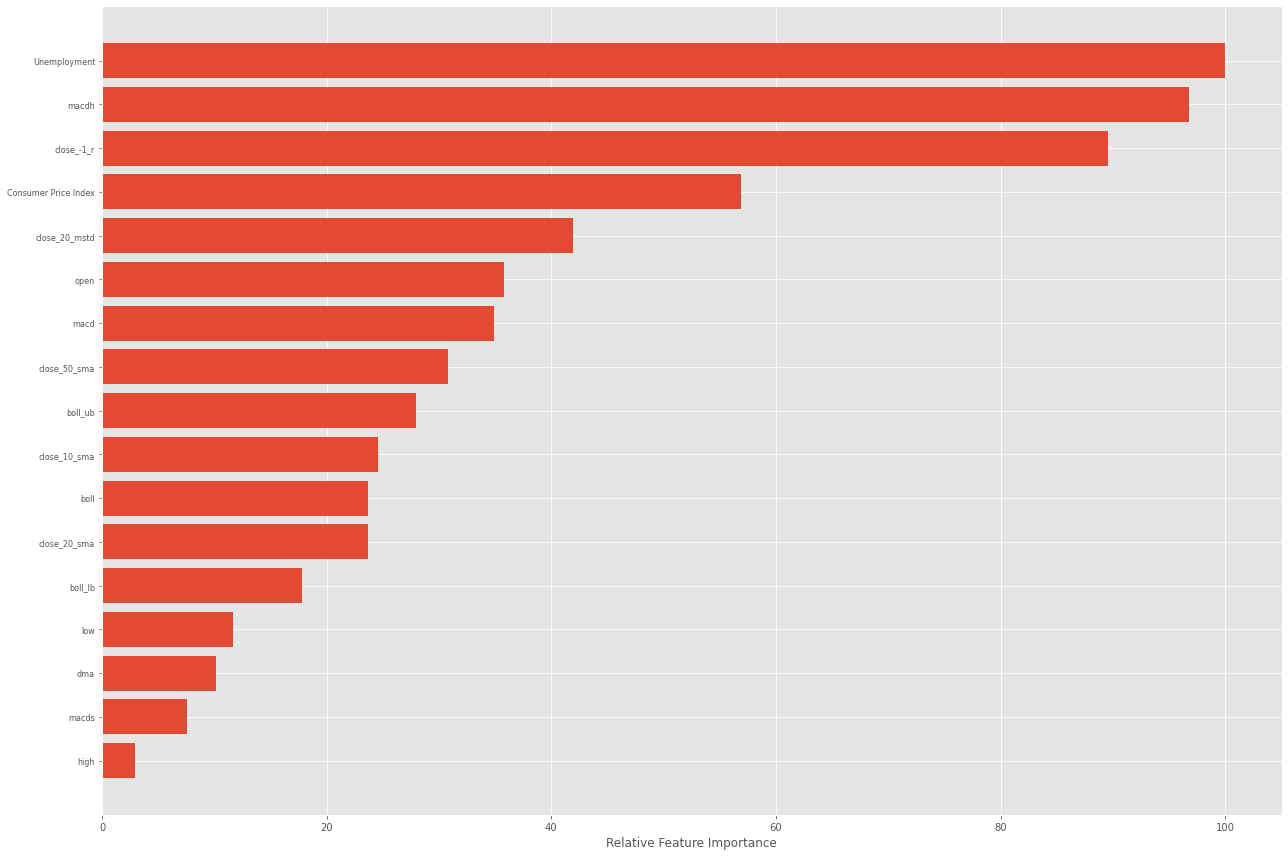

In [14]:
# analyze feature importance with Log regression 
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(18,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(train_x.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()